In [100]:
%load_ext autoreload
%autoreload 2

# general imports
import numpy as np
import pickle, time, datetime, itertools, multiprocessing
import matplotlib.pyplot as plt
import ipywidgets as widgets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Tensorflow and sklearn imports

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPool1D, Conv2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm

from kerastuner.tuners import RandomSearch, hyperband
from kerastuner.engine.hyperparameters import HyperParameters

from tqdm.keras import TqdmCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\gustavo\AppData\Local\Temp/ipykernel_31256/3709234262.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, hyperband


Custon functions import

In [4]:
from formata_dados import *
from processa_dados import *

## Importing the dataset and creating the data input and output for the network

All the data was treated and imported using the data_cleaning notebook

In [5]:
dataset_path = 'Dataset\\dados_pickle\\'  # folder for the already threated dataset 
# If you are on linux or mac os, use / instead of \\

with open(dataset_path + "dados_semruido_ok.pkl", "rb") as dados_ok_semruidos:
        dados_sem_ruidos = pickle.load(dados_ok_semruidos)[0]
with open(dataset_path + "dados_semruido_agua_ok.pkl", "rb") as dados_agua_ok:
        dados_semruido_agua_ok= pickle.load(dados_agua_ok)[0]
with open(dataset_path + "dados_semruido_aspartame_ok.pkl", "rb") as dados_aspartame_ok:
        dados_semruido_aspartame_ok = pickle.load(dados_aspartame_ok)[0]
with open(dataset_path + "dados_semruido_sucralose_ok.pkl", "rb") as dados_sucralose_ok:
        dados_semruido_sucralose_ok = pickle.load(dados_sucralose_ok)[0]
with open(dataset_path + "dados_semruido_acucar_ok.pkl", "rb") as dados_acucar_ok:
        dados_semruido_acucar_ok = pickle.load(dados_acucar_ok)[0]

In [105]:
X = dados_sem_ruidos[:,:-4]
y = dados_sem_ruidos[:,-4:]
X_agua = dados_semruido_agua_ok[:,:-4]
y_agua = dados_semruido_agua_ok[:,-4:]
X_acucar = dados_semruido_acucar_ok[:,:-4]
y_acucar = dados_semruido_acucar_ok[:,-4:]
X_aspartame = dados_semruido_aspartame_ok[:,:-4]
y_aspartame = dados_semruido_aspartame_ok[:,-4:]
X_sucralose = dados_semruido_sucralose_ok[:,:-4]
y_sucralose = dados_semruido_sucralose_ok[:,-4:]

# EVP

### Visualizando um potencial:

In [222]:
def plot_single(i, total_time, n_smoth_1, n_smoth_2=0):
    plt.plot(np.convolve(X[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1))
    plt.plot(X[i, :int(256*total_time)])

In [223]:
coleta = widgets.IntSlider(value=10, min=0, max=67, description='coleta')
total_time = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.2, description='Time(s)')
n_smoth_1 = widgets.IntSlider(value=20, min=1, max=100, step=5, description='MédiaMóvel')
ui = widgets.VBox([coleta, total_time, n_smoth_1])
out = widgets.interactive_output(plot_single, 
              {'i': coleta, 'total_time': total_time, 'n_smoth_1':n_smoth_1})
display(ui, out)

Output()

In [224]:
def plot_all_type(tipo,  total_time, n_smoth_1):
    if tipo == 'Água':
        X = X_agua
    elif tipo == 'Sucralose':
        X = X_sucralose
    elif tipo == 'Aspartame':
        X = X_aspartame
    else:
        X = X_acucar
    X_smoth = np.ndarray(X[:, :int(256*total_time)+n_smoth_1-1].shape)
    for i in range(X.shape[0]):
        X_smoth[i, :] = np.convolve(X[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1)
    plt.plot(X_smoth.sum(axis=0))

In [225]:
total_time = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.2, description='Time(s)')
n_smoth_1 = widgets.IntSlider(value=20, min=1, max=100, step=5, description='MédiaMóvel')
bebida = widgets.Dropdown(options=['Açúcar','Água', 'Sucralose', 'Aspartame'],value='Açúcar')
ui = widgets.VBox([total_time, n_smoth_1, bebida])
out = widgets.interactive_output(plot_all_type, 
              {'tipo': bebida, 'total_time': total_time, 'n_smoth_1':n_smoth_1})
display(ui, out)

Output()

In [226]:
def plot_all_together(total_time, n_smoth_1):
    X_smoth_agua = np.ndarray(X_agua[:, :int(256*total_time)+n_smoth_1-1].shape)
    X_smoth_acucar = np.ndarray(X_acucar[:, :int(256*total_time)+n_smoth_1-1].shape)
    X_smoth_aspartame = np.ndarray(X_aspartame[:, :int(256*total_time)+n_smoth_1-1].shape)
    X_smoth_sucralose = np.ndarray(X_sucralose[:, :int(256*total_time)+n_smoth_1-1].shape)
    for i in range(X_agua.shape[0]):
        X_smoth_agua[i, :] = np.convolve(X_agua[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1)
    for i in range(X_sucralose.shape[0]):
        X_smoth_sucralose[i, :] = np.convolve(X_sucralose[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1)
    for i in range(X_acucar.shape[0]):
        X_smoth_acucar[i, :] = np.convolve(X_acucar[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1)
    for i in range(X_aspartame.shape[0]):
        X_smoth_aspartame[i, :] = np.convolve(X_aspartame[i, :int(256*total_time)], np.ones(n_smoth_1)/n_smoth_1)
    plt.plot(X_smoth_agua.sum(axis=0))
    plt.plot(X_smoth_sucralose.sum(axis=0))
    plt.plot(X_smoth_acucar.sum(axis=0))
    plt.plot(X_smoth_aspartame.sum(axis=0))

In [227]:
total_time = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.2, description='Time(s)')
n_smoth_1 = widgets.IntSlider(value=20, min=1, max=100, step=5, description='MédiaMóvel')
ui = widgets.VBox([total_time, n_smoth_1])
out = widgets.interactive_output(plot_all_together, 
              {'total_time': total_time, 'n_smoth_1':n_smoth_1})
display(ui, out)

Output()

Options parameters for data multiplication

In [99]:
window_time = 5       # the size of each data sample in seconds - array size = window_time * 512
window_slide = 0.001   # the stride in seconds
t_inicial = 0.0       # start value for the data in seconds (time before that will be ignored)
delta_time = 6        # the amount of data that will be used (time after delta_time + t_inicial will be ignored)

In [100]:
liquidos = ['agua   ', 'acucar  ', 'aspartame', 'sucralose']

X_agua_train, X_agua_test, y_agua_train, y_agua_test = train_test_split(X_agua, y_agua, test_size=0.3, random_state=42)
X_acucar_train, X_acucar_test, y_acucar_train, y_agua_test = train_test_split(X_acucar, y_acucar, test_size=0.3, random_state=42)
X_aspartame_train, X_aspartame_test, y_aspartame_train, y_agua_test = train_test_split(X_aspartame, y_aspartame, test_size=0.3, random_state=42)
X_sucralose_train, X_sucralose_test, y_sucralose_train, y_sucralose_test = train_test_split(X_sucralose, y_sucralose, test_size=0.3, random_state=42)

X_agua_train, y_agua_train = multiplica_dados(X_agua_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_agua)
X_acucar_train, y_acucar_train = multiplica_dados(X_acucar_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_acucar)
X_aspartame_train, y_aspartame_train = multiplica_dados(X_aspartame_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_aspartame)
X_sucralose_train, y_sucralose_train = multiplica_dados(X_sucralose_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_sucralose)

X_agua_test, y_agua_test = multiplica_dados(X_agua_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_agua)
X_acucar_test, y_acucar_test = multiplica_dados(X_acucar_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_acucar)
X_aspartame_test, y_aspartame_test = multiplica_dados(X_aspartame_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_aspartame)
X_sucralose_test, y_sucralose_test = multiplica_dados(X_sucralose_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, window_slide, y_sucralose)

y_agua_train = y_agua_train[:,1]
y_acucar_train = y_acucar_train[:,1]
y_aspartame_train = y_aspartame_train[:,1]
y_sucralose_train = y_sucralose_train[:,1]
y_agua_test = y_agua_test[:,1]
y_acucar_test = y_acucar_test[:,1]
y_aspartame_test = y_aspartame_test[:,1]
y_sucralose_test = y_sucralose_test[:,1]

X_train = np.concatenate((X_agua_train, X_acucar_train, X_aspartame_train, X_sucralose_train))
X_test = np.concatenate((X_agua_test, X_acucar_test, X_aspartame_test, X_sucralose_test))
y_train = np.concatenate((y_agua_train, y_acucar_train, y_aspartame_train, y_sucralose_train))
y_test = np.concatenate((y_agua_test, y_acucar_test, y_aspartame_test, y_sucralose_test))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=None, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=None, dtype='float32')

X_train_len = X_train.shape[0]
X_all = tf.keras.utils.normalize(np.concatenate((X_train, X_test)), axis=-1, order=2)
X_train = X_all[:X_train_len,:]
X_test = X_all[X_train_len:,:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 4))
y_test = np.reshape(y_test, (y_test.shape[0], 4))

Let's check if data was imported and is in the correct format:

In [32]:
print(f'Input format: X_train:{X_train.shape} \t y_train:{y_train.shape} \t X_test:{X_test.shape} \t y_test:{y_test.shape}')

Input format: X_train:(2760, 2560, 1) 	 y_train:(2760, 4) 	 X_test:(1320, 2560, 1) 	 y_test:(1320, 4)


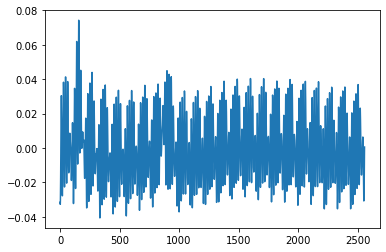

In [33]:
plt.plot(X_train[0])

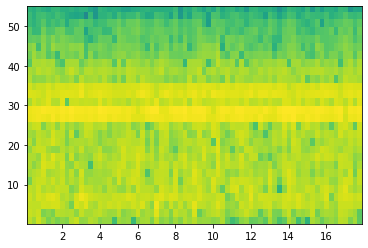

In [103]:
plt.specgram(X_acucar[5], Fs=512)
plt.axis(ymin=0.1, ymax=55)
plt.show()

In [19]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

## Now we create the Neural network and train it

Creating a NN with keras fuctional api

In [80]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)

Inputs = tf.keras.Input(shape=(X_train.shape[1],1))

cv1 = Dropout(0.2)(Inputs)
cv1 = Conv1D(filters=500, kernel_size=1400, activation='relu', kernel_constraint=MaxNorm(1.), strides=5)(cv1)
cv1 = MaxPooling1D(pool_size=10)(cv1)
cv1 = Flatten()(cv1)
cv1 = Dropout(0.4)(cv1)
cv1 = Dense(200, activation='relu')(cv1)

cv2 = Dropout(0.4)(Inputs)
cv2 = Conv1D(filters=500, kernel_size=150, activation='relu', kernel_constraint=MaxNorm(1.), strides=5)(cv2)
cv2 = MaxPooling1D(pool_size=10)(cv2)
cv2 = Flatten()(cv2)
cv2 = Dropout(0.4)(cv2)
cv2 = Dense(200, activation='relu')(cv2)

cv3 = Dropout(0.2)(Inputs)
cv3 = Conv1D(filters=500, kernel_size=500, activation='relu', kernel_constraint=MaxNorm(1.), strides=5)(cv3)
cv3 = MaxPooling1D(pool_size=10)(cv3)
cv3 = Flatten()(cv3)
cv3 = Dropout(0.4)(cv3)
cv3 = Dense(200, activation='relu')(cv3)

merge = concatenate([cv1, cv2, cv3])

x = Dropout(0.2)(merge)
x = Dense(400, activation='relu')(x)
x = Dropout(0.2)(x)
Oututs = Dense(4, activation='softmax')(x)


model = tf.keras.Model(inputs=Inputs, outputs=Oututs)
model.compile(
    loss='categorical_crossentropy', #losses.CategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0, shuffle=True, callbacks=[TqdmCallback(verbose=1), es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.31136, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.31136 to 0.39545, saving model to best_model.h5

Epoch 00003: val_accuracy improved from 0.39545 to 0.41045, saving model to best_model.h5

Epoch 00004: val_accuracy improved from 0.41045 to 0.41773, saving model to best_model.h5

Epoch 00005: val_accuracy improved from 0.41773 to 0.44227, saving model to best_model.h5

Epoch 00006: val_accuracy did not improve from 0.44227

Epoch 00007: val_accuracy did not improve from 0.44227

Epoch 00008: val_accuracy did not improve from 0.44227

Epoch 00009: val_accuracy did not improve from 0.44227

Epoch 00010: val_accuracy did not improve from 0.44227

Epoch 00011: val_accuracy did not improve from 0.44227

Epoch 00012: val_accuracy did not improve from 0.44227

Epoch 00013: val_accuracy improved from 0.44227 to 0.44455, saving model to best_model.h5

Epoch 00014: val_accuracy did not improve from 0.44455

Epoch 00

Let's see the best score

In [61]:
model_best = tf.keras.models.load_model('best_model.h5')

This is the NN topology

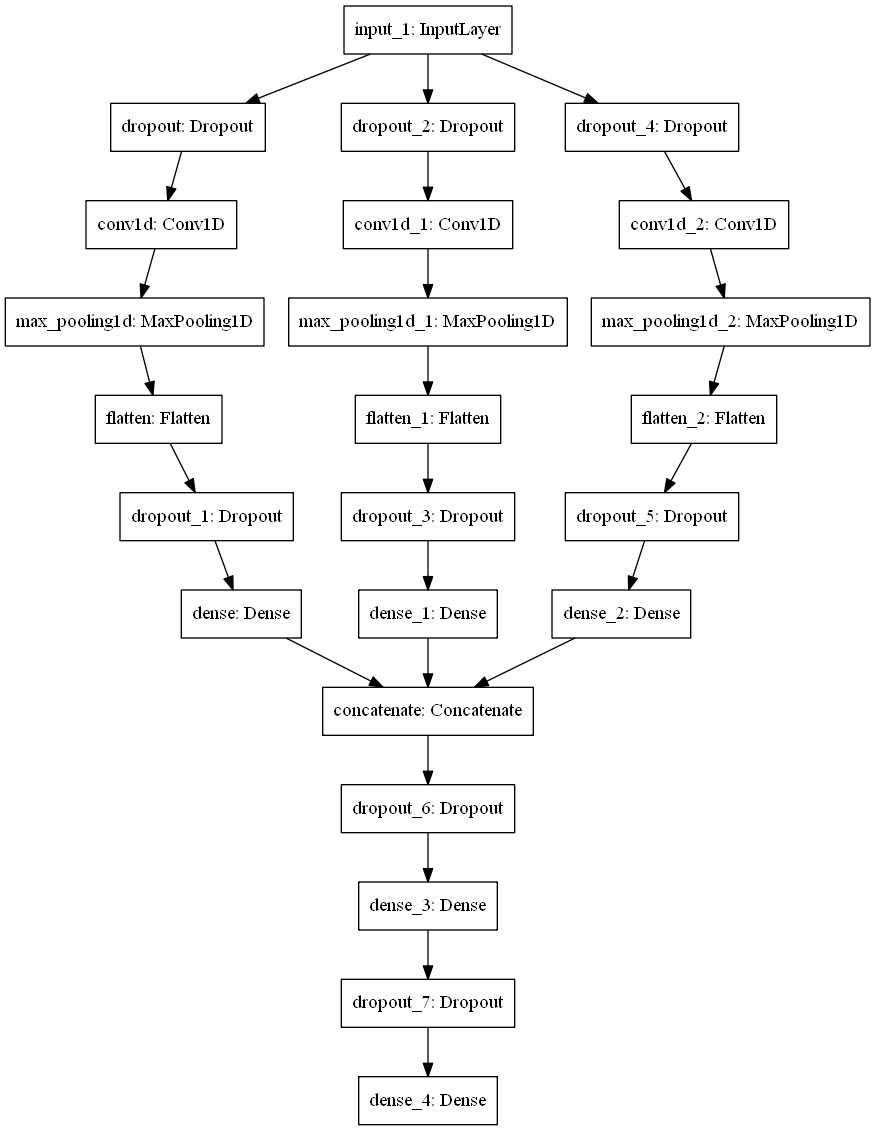

In [62]:
tf.keras.utils.plot_model(
    model_best, to_file='model.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

Importing and printing our best result

In [84]:
model_best = tf.keras.models.load_model('Tensorflow_Models\\best_model_601.h5')

In [101]:
model_best.evaluate(X_test, y_test)

22000/22000 [==============================] - ETA: 27s - loss: 0.5261 - accuracy: 1.000 - ETA: 7s - loss: 0.9620 - accuracy: 0.187 - ETA: 5s - loss: 0.9569 - accuracy: 0.17 - ETA: 5s - loss: 0.9327 - accuracy: 0.18 - ETA: 5s - loss: 0.8369 - accuracy: 0.32 - ETA: 4s - loss: 0.8368 - accuracy: 0.38 - ETA: 4s - loss: 0.8574 - accuracy: 0.38 - ETA: 4s - loss: 1.1516 - accuracy: 0.32 - ETA: 4s - loss: 1.2706 - accuracy: 0.35 - ETA: 4s - loss: 1.1083 - accuracy: 0.43 - ETA: 3s - loss: 0.9837 - accuracy: 0.50 - ETA: 3s - loss: 0.8939 - accuracy: 0.54 - ETA: 3s - loss: 0.8207 - accuracy: 0.58 - ETA: 3s - loss: 0.7554 - accuracy: 0.62 - ETA: 3s - loss: 0.7027 - accuracy: 0.65 - ETA: 3s - loss: 0.6588 - accuracy: 0.67 - ETA: 3s - loss: 0.6245 - accuracy: 0.69 - ETA: 3s - loss: 0.6118 - accuracy: 0.70 - ETA: 3s - loss: 1.3512 - accuracy: 0.67 - ETA: 3s - loss: 2.4921 - accuracy: 0.63 - ETA: 3s - loss: 3.5624 - accuracy: 0.60 - ETA: 2s - loss: 4.7915 - accuracy: 0.57 - ETA: 2s - loss: 6.4099 - a

[6.181768329076739, 0.6544545]

Confusion matrix, without normalization
[[3498  617  711  174]
 [  12 1631  493 2864]
 [   0    4 3269 2727]
 [   0    0    0 6000]]
agua    	 0.6996 %
acucar   	 0.3262 %
aspartame 	 0.5448333333333333 %
sucralose 	 1.0 %


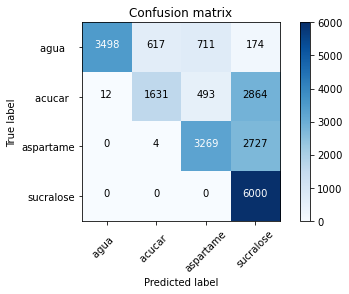

In [102]:
model_best.evaluate(X_test, y_test, verbose=False)
y_pred = model_best.predict(X_test)
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, liquidos)
for i in range(4):
    print(f'{liquidos[i]} \t {cm[i,i]/cm[i,:].sum()} %')